# Cluster similar books together for suggestions

Based on the dataset created from the book catalog of the site audiocite.net

## Import basic libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load and explore the dataset

In [2]:
df = pd.read_csv("./books-data.csv")

In [3]:
df.shape

(3651, 342)

In [4]:
df.head(5)

,23,1,R,139,77515,1.1,1.2,1.3,1.4,1.5,...,0.321,0.322,0.323,0.324,0.325,0.326,0.327,0.328,0.329,0.330
0,24,2,C,60,6901,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,61,3,R,88,22623,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,66,4,C,40,24285,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,67,5,D,28,11687,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,68,5,R,69,8808,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Definition of features

| Feature  | Description | Comments |
|--------------|-------------|--------|
| id | Book ID | |
| author | Encoded book author | All unique authors are converted to unique numbers |
| genre | The genre | 'R' for 'Romain' etc. |
| duration | Duration in full minutes | |
| downloads | Number of downloads | |
| reader | Encoded reader | All unique readers are converted to unique numbers |
| tagN | If the tag is present | All tags are encoded using numbers |

## Feature Selection

Tags are encoded using one hot encoding, which results in a very sparse matrix. We'll try to apply the feature selection to choose the tags that are most valuable.

### Remove features with low variance

In [5]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
df_selected = pd.DataFrame(sel.fit_transform(df.iloc[:, 6:]))

In [6]:
df_selected = pd.concat([df.iloc[:, 0:6], df_selected], axis = 1)
df_selected.columns = ['id', 'author', 'genre', 'duration', 'downloads', 'reader', 'tag_1', 'tag_2', 'tag_3']

In [7]:
df_selected.shape

(3651, 9)

In [8]:
df_selected.head(10)

,id,author,genre,duration,downloads,reader,tag_1,tag_2,tag_3
0,24,2,C,60,6901,2,1,0,0
1,61,3,R,88,22623,1,1,1,0
2,66,4,C,40,24285,2,1,0,0
3,67,5,D,28,11687,1,1,0,0
4,68,5,R,69,8808,1,1,1,0
5,70,6,N,9,4503,2,1,1,1
6,72,7,PH,83,19314,3,1,0,0
7,74,6,N,18,6707,2,1,1,0
8,77,8,C,89,6346,2,1,0,0
9,78,9,R,370,17842,4,1,0,0


In [9]:
df = df_selected

## Mold the data

Change genre from string to float

In [10]:
genre_map = {'AN': 1.0, 'JN': 2.0, 'E': 3.0, 'C': 4.0, 'CS': 5.0, 'D': 6.0, 'F': 7.0, 'H': 8.0, 'N': 9.0, 'PH': 10.0, 'PA': 11.0, 'P': 12.0, 'RL': 13.0, 'R': 14.0, 'SF': 15.0, 'TH': 16.0}
df['genre'] = df['genre'].map(genre_map)

In [11]:
df.head(5)

,id,author,genre,duration,downloads,reader,tag_1,tag_2,tag_3
0,24,2,4.0,60,6901,2,1,0,0
1,61,3,14.0,88,22623,1,1,1,0
2,66,4,4.0,40,24285,2,1,0,0
3,67,5,6.0,28,11687,1,1,0,0
4,68,5,14.0,69,8808,1,1,1,0


### Verify that all the data is numeric

In [12]:
df.applymap(lambda x: isinstance(x, (int, float))).head(5)

,id,author,genre,duration,downloads,reader,tag_1,tag_2,tag_3
0,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True


## Check for correlated features

Correlated features don't add any information, since they are expressing the same data in different ways.

In [13]:
def plot_correlation(df, size = 12):
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr) # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

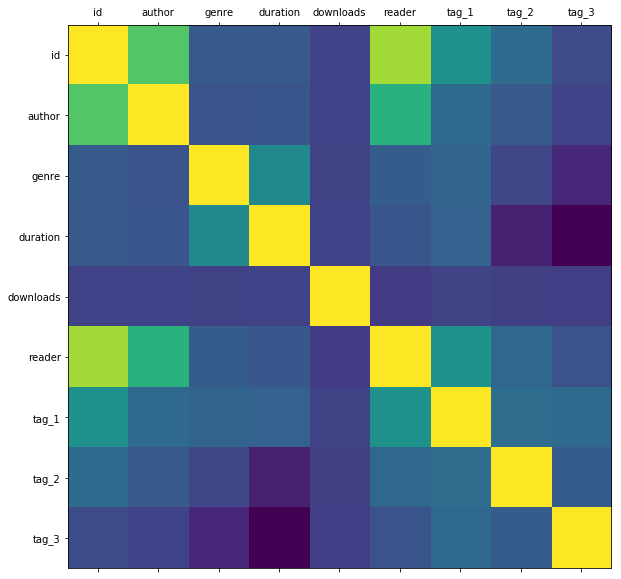

In [14]:
plot_correlation(df, 10)

## Scale features

### Check for outliers

If there is no outliers, we could use Max-Min Scaling

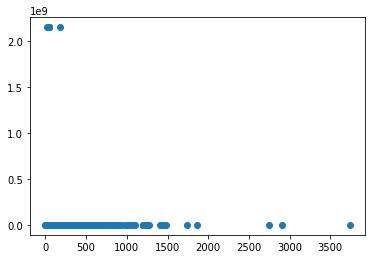

In [15]:
x = df.duration
y = df.downloads

plt.scatter(x, y)
plt.show()

We are going to use Z-Score Scaling

In [16]:
from sklearn.preprocessing import StandardScaler

df_ss = StandardScaler().fit_transform(df.loc[:, 'duration':'downloads'])

C:\Users\Artem\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Artem\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
df_ss = pd.DataFrame(df_ss)
df_ss.columns = ['duration', 'downloads']

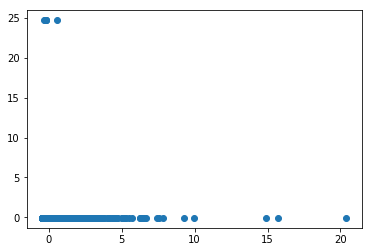

In [18]:
x = df_ss.duration
y = df_ss.downloads

plt.scatter(x, y)
plt.show()

In [19]:
df_scaled = pd.concat([df.loc[:, 'id':'genre'], df_ss], axis = 1)
df_scaled = pd.concat([df_scaled, df.loc[:, 'reader':'tag_3']], axis = 1)

In [20]:
df_scaled.head(5)

,id,author,genre,duration,downloads,reader,tag_1,tag_2,tag_3
0,24,2,4.0,-0.122300,-0.040597,2,1,0,0
1,61,3,14.0,0.033991,-0.040416,1,1,1,0
2,66,4,4.0,-0.233937,-0.040397,2,1,0,0
3,67,5,6.0,-0.300919,-0.040542,1,1,0,0
4,68,5,14.0,-0.072064,-0.040575,1,1,1,0


In [21]:
df = df_scaled

## Apply KMeans

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(df.loc[:, 'author' : 'tag_3'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
df.loc[:,'label'] = kmeans.labels_

In [24]:
df.head(5)

,id,author,genre,duration,downloads,reader,tag_1,tag_2,tag_3,label
0,24,2,4.0,-0.122300,-0.040597,2,1,0,0,1
1,61,3,14.0,0.033991,-0.040416,1,1,1,0,1
2,66,4,4.0,-0.233937,-0.040397,2,1,0,0,1
3,67,5,6.0,-0.300919,-0.040542,1,1,0,0,1
4,68,5,14.0,-0.072064,-0.040575,1,1,1,0,1


Text(0.5, 0, 'duration')

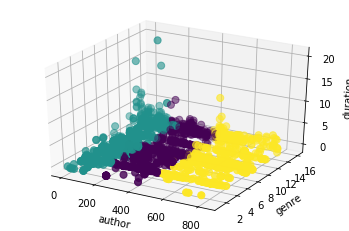

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.loc[:, 'author'], df.loc[:, 'genre'], df.loc[:, 'duration'], c=df.loc[:,'label'], s=50, cmap='viridis')
ax.set_xlabel('author')
ax.set_ylabel('genre')
ax.set_zlabel('duration')

### Fails because we have categorical data - groups authors with sequential ids together

### Print groups

In [29]:
groups = df_scaled.groupby('label')
groups['id'].apply(lambda ids: [id for id in ids])

label
0    [1102, 1145, 1160, 1173, 1176, 1180, 1193, 119...
1    [24, 61, 66, 67, 68, 70, 72, 74, 77, 78, 79, 8...
2    [3447, 3448, 3471, 3475, 3476, 3489, 3491, 349...
Name: id, dtype: object

## Apply K-prototype

In [34]:
from kmodes.kprototypes import KPrototypes

kproto = KPrototypes(n_clusters=5, init='Cao', verbose=1)
clusters = kproto.fit_predict(df.loc[:, 'author' : 'tag_3'], categorical=[0, 1, 4])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1380, ncost: 5498.961419828531
Run: 1, iteration: 2/100, moves: 416, ncost: 5401.841846357239
Run: 1, iteration: 3/100, moves: 133, ncost: 5373.26235094348
Run: 1, iteration: 4/100, moves: 4, ncost: 5373.19912017952
Run: 1, iteration: 5/100, moves: 1, ncost: 5373.191054210851
Run: 1, iteration: 6/100, moves: 0, ncost: 5373.191054210851
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1777, ncost: 8741.728305331402
Run: 2, iteration: 2/100, moves: 199, ncost: 8660.173648305676
Run: 2, iteration: 3/100, moves: 44, ncost: 8649.711689039472
Run: 2, iteration: 4/100, moves: 8, ncost: 8649.19993418435
Run: 2, iteration: 5/100, moves: 3, ncost: 8649.102831509108
Run: 2, iteration: 6/100, moves: 5, ncost: 8648.954194546153
Run: 2, iteration: 7/100, moves: 0, ncost: 8648.954194546153
Init: initializing centroids
Init: in

In [35]:
df.loc[:,'label1'] = clusters

In [36]:
df.head(5)

,id,author,genre,duration,downloads,reader,tag_1,tag_2,tag_3,label,label1
0,24,2,4.0,-0.122300,-0.040597,2,1,0,0,1,4
1,61,3,14.0,0.033991,-0.040416,1,1,1,0,1,1
2,66,4,4.0,-0.233937,-0.040397,2,1,0,0,1,4
3,67,5,6.0,-0.300919,-0.040542,1,1,0,0,1,4
4,68,5,14.0,-0.072064,-0.040575,1,1,1,0,1,1


Text(0.5, 0, 'duration')

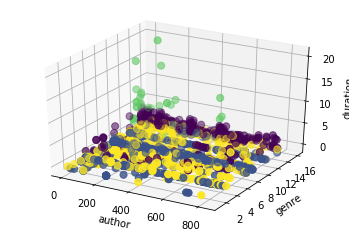

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.loc[:, 'author'], df.loc[:, 'genre'], df.loc[:, 'duration'], c=df.loc[:,'label1'], s=50, cmap='viridis')
ax.set_xlabel('author')
ax.set_ylabel('genre')
ax.set_zlabel('duration')

### Print groups

In [38]:
groups = df_scaled.groupby('label1')
booksingrups = groups['id'].apply(lambda ids: [id for id in ids])
booksingrups

label1
0    [78, 86, 229, 246, 282, 300, 304, 317, 363, 41...
1    [61, 68, 70, 74, 80, 81, 82, 83, 84, 85, 91, 9...
2                 [1885, 2339, 2460, 2467, 2483, 2515]
3    [516, 538, 787, 810, 922, 1057, 1284, 1382, 15...
4    [24, 66, 67, 72, 77, 79, 87, 90, 92, 103, 106,...
Name: id, dtype: object

## Save results to file

In [39]:
# booksingrups.to_csv('clusters.out')